Image path: data/placabrasil.jpg


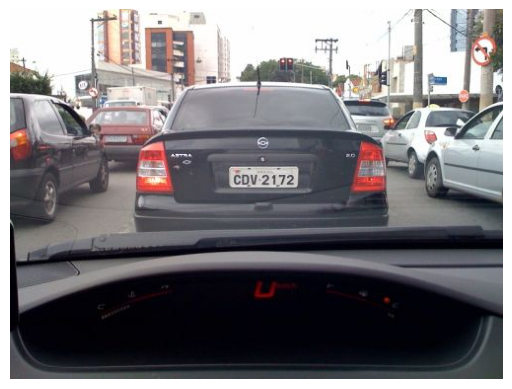

Image loaded. Performing segmentation. Please wait...


KeyboardInterrupt: 

In [1]:
import os
import cv2
import torch
import supervision as sv
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

class ImageSegmentation:
    def __init__(self, model_type="vit_h", checkpoint_path=None, grid_size=(1, 2), mask_grid_size=(8, 8), mask_size=(16, 16), color_lookup=sv.ColorLookup.INDEX):
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model_type = model_type
        self.checkpoint_path = checkpoint_path
        self.grid_size = grid_size
        self.mask_grid_size = mask_grid_size
        self.mask_size = mask_size
        self.color_lookup = color_lookup
        self._load_model()

    def _load_model(self):
        if self.checkpoint_path is None:
            raise ValueError("Please provide a valid checkpoint path.")

        self.sam = sam_model_registry[self.model_type](checkpoint=self.checkpoint_path).to(device=self.device)
        self.mask_generator = SamAutomaticMaskGenerator(self.sam)

    def load_model(self, checkpoint_path):
        self.checkpoint_path = checkpoint_path
        self._load_model()

    def segment_image(self, image_path):
        image_bgr = cv2.imread(image_path)

        
        if image_bgr is None:
            raise ValueError(f"Failed to load image from path: {image_path}")

        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

        print("Image loaded. Performing segmentation. Please wait...")

        sam_result = self.mask_generator.generate(image_rgb)

        mask_annotator = sv.MaskAnnotator(color_lookup=self.color_lookup)
        detections = sv.Detections.from_sam(sam_result=sam_result)
        annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

        return image_bgr, annotated_image, sam_result

if __name__ == "__main__":
    # Example usage
    home = os.getcwd()
    checkpoint_path = os.path.join(home, "weights", "sam_vit_h_4b8939.pth")

    # Add the image path
    image_path = "data/SuaIMG.jpg"


    print(f"Image path: {image_path}")
    if not os.path.isfile(image_path):
        raise ValueError(f"Image file not found: {image_path}")

    test_image = cv2.imread(image_path)
    if test_image is None:
        raise ValueError(f"Failed to load image from path: {image_path}")

    # Load and display the image to check if everything is correct
    test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

    plt.imshow(test_image_rgb)
    plt.axis('off')
    plt.show()

    segmentation_model = ImageSegmentation(model_type="vit_h", checkpoint_path=checkpoint_path)
    source_image, annotated_image, sam_result = segmentation_model.segment_image(image_path)

    # Visualize source image and annotated image
    sv.plot_images_grid(
        images=[source_image, annotated_image],
        grid_size=segmentation_model.grid_size,
        titles=['source image', 'annotated image']
    )

    # Visualize individual masks with numbering
    masks = [
        {'mask': mask['segmentation'], 'area': mask['area']}
        for mask
        in sorted(sam_result, key=lambda x: x['area'], reverse=True)
    ]

    numbered_masks = [
        {'mask': mask['mask'], 'number': idx + 1}
        for idx, mask in enumerate(masks)
    ]

    sv.plot_images_grid(
        images=[mask['mask'] for mask in numbered_masks],
        # adjust grid_size and size, as needed
        grid_size=(8, int(len(masks) / 8)),
        size=segmentation_model.mask_size,
        titles=[f'Mask {mask["number"]}' for mask in numbered_masks]
    )